# Tohoku tsunami inversion part IV:
### Inversion for full initial condition with higher resolution

The only difference from notebook 4 is that we remove the maximum iteration condition.

Other things we might want to tweak:
* longer time duration;
* linear vs. nonlinear shallow water equations;
* different discretisations;
* wetting and drying;
* `ftol` for optimisation routine;
* weighting certain gauges?
* goal-oriented mesh adaptation to guide optimisation?

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.swe.tsunami.conversion import from_latlon
from adapt_utils.misc import box, ellipse #, bump

Misc plotting routines

In [5]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [6]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [7]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

Function for extracting timeseries data from file

In [8]:
def read_and_sample(g, sample=1):
    """Copied from `resources/gauges/plot_gauge_data.ipynb`"""
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t = []
    d = []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        running = 0
        for i in range(num_lines):
            line = f.readline()
            time, dat = line.split()
            time = float(time)
            dat = float(dat)
            running += dat
            if i % sample == 0 and i > 0:
                if time < time_prev:
                    break  # FIXME
                t.append(0.5*(time + time_prev))
                d.append(running/sample)
                running = 0
                time_prev = time
    return t, d

Define a mesh and a Taylor-Hood space upon it.

For quick results, let's just use the coarsest mesh of the hierarchy.

In [9]:
# level = 0
level = 1
# level = 2
op = TohokuOptions(level=level)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1
# plot_mesh(mesh);

Define fields for forward model, e.g. bathymetry from GEBCO.

In [10]:
b = Function(P1, name="Bathymetry").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))
# plot_fields(eta_init, b, f);

Hand-coded Crank-Nicolson / Taylor-Hood solver for shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0
$$
equipped with boundary conditions
$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\partial\Omega}\equiv0\qquad
    \eta|_{\Gamma_{100}}\equiv0.
$$

In [11]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

We use the initial free surface computed using inversion in __[Saito et al. 2011]__ as an initial guess.

Note that if we were to invert w.r.t. the full initial condition then we would very likely get non-zero initial velocity.
As such, we filter the initial condition using a kernel function which zeroes out the velocity.

In addition, we assume that the initial free surface is only non-zero in a rectangular region aligned with the fault centred at the earthquake epicentre, of widths 280km and 140km parallel and perpendicular to the fault, resp.
This is accounted for in the free surface component of the kernel function.

In [12]:
initial_surface = Function(P1, name="Initial surface")  # This is the field we will be optimising
initial_surface.interpolate(op.set_initial_surface(P1));

In [13]:
xy = tuple(from_latlon(38.0, 143.2, force_zone_number=54))
radii = (140e+03, 280e+03)
angle = pi/10
loc = [xy + radii, ]

kernel = Function(TaylorHood)
kernel_u, kernel_eta = kernel.split()
kernel_eta.interpolate(box(loc, mesh, rotation=angle));

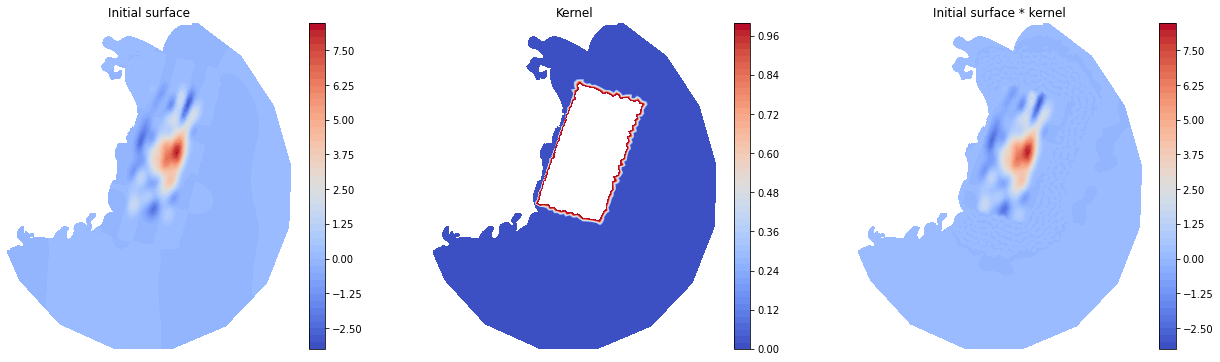

In [14]:
q_.project(kernel*initial_surface)  # This acts to zero out the initial velocity
u_, eta_ = q_.split()
u_.dat.name = "Initial velocity * kernel"
eta_.dat.name = "Initial surface * kernel"
kernel_eta.dat.name = "Kernel"
axes = plot_fields(initial_surface, kernel_eta, eta_, height=6);

Consider a time-dependent quantity of interest (QoI) which measures the goodness-of-fit at gauges

$$
J(\mathbf u,\eta)=\sum_{t\in\mathcal T}\sum_{g\in\mathcal G}\big|\:\eta(\mathbf x_g,t)-\eta_g(t)\:\big|,
$$

where $\mathcal T\subset(0, T]$ is a finite set of time levels and $\mathcal G\subset\Omega$ is a finite set of gauge coordinates.
For a given gauge $g$, $\eta_g(t)$ is the observed free surface height at time $t$ and $\mathbf x_g$ provides the UTM coordinates.

In order to evaluate such a QoI we first need to be able to represent the elevation at each gauge in $\mathcal H^1(\Omega)$.
Our approach is to use indicator functions of as narrow a radius as we can get away with.

In [15]:
op.gauges.pop('21418')  # This pressure gauge isn't within the domain
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    x, y = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([(x, y, radius), ], mesh), P0)

Next we need timeseries data at the gauges. (See notebook `resources/gauges/plot_gauge_data.ipynb`.)

__Notes__
  * We have done some averaging over samples in order to reduce noise.
  * The GPS gauges 801-806 contain `NaN`s.

In [16]:
for gauge in gauges:
    sample = 60 if gauge[0] == 'P' else 12
    op.gauges[gauge]['times'], op.gauges[gauge]['data'] = read_and_sample(gauge, sample=sample)
    
times = np.array(op.gauges['P02']['times'])
n = len(times)
for gauge in op.gps_gauges:
    op.gauges[gauge]['data'] = op.gauges[gauge]['data'][:-1]
for gauge in op.gauges:
    assert len(op.gauges[gauge]['data']) == n
    
for gauge in gauges:
    for i in range(n):
        if not np.isnan(op.gauges[gauge]['data'][i]):
            op.gauges[gauge]['data'] = np.array(op.gauges[gauge]['data']) - op.gauges[gauge]['data'][i]
            break

Now run the forward model, time integrating the QoI as time progresses.

In [17]:
t = 0.0
i = 0
J = 0
i_obs = 0
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
t_obs = Constant(op.end_time / len(times))
with stop_annotating():
    for gauge in gauges:
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx)
while t < op.end_time:
    solver.solve()
    
    # Time integrate QoI
    #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
    if np.allclose(t, times[i_obs]):
        print("observation {:2d} (t = {:.2f})".format(i_obs, t))
        weight = 1.0
        if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt:
            weight = 0.5
        u, eta = q.split()
        for gauge in op.gauges:
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
            eta_obs = op.gauges[gauge]['data'][i_obs]
            if not np.isnan(eta_obs):
                
                # Discrete form
                diff = abs(eta_discrete - eta_obs)
                op.gauges[gauge]['diff'].append(diff)
#                 J += weight*t_obs*diff

                # Continuous form
                diff = op.gauges[gauge]['indicator']*abs(eta - eta_obs)
                J_inc = assemble(weight*t_obs*diff*dx)
                J += J_inc
                with stop_annotating():
                    op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx)/op.gauges[gauge]['area'])
            else:
                op.gauges[gauge]['diff'].append(np.nan)
                op.gauges[gauge]['diff_smooth'].append(np.nan)
        i_obs += 1
        
        
    q_.assign(q)
    t += op.dt
    i += 1
    if i_obs == len(times):
        break
print("Quantity of interest = {:.4e}".format(J))

observation  0 (t = 30.00)
observation  1 (t = 90.00)
observation  2 (t = 150.00)
observation  3 (t = 210.00)
observation  4 (t = 270.00)
observation  5 (t = 330.00)
observation  6 (t = 390.00)
observation  7 (t = 450.00)
observation  8 (t = 510.00)
observation  9 (t = 570.00)
observation 10 (t = 630.00)
observation 11 (t = 690.00)
observation 12 (t = 750.00)
observation 13 (t = 810.00)
observation 14 (t = 870.00)
observation 15 (t = 930.00)
observation 16 (t = 990.00)
observation 17 (t = 1050.00)
observation 18 (t = 1110.00)
observation 19 (t = 1170.00)
observation 20 (t = 1230.00)
observation 21 (t = 1290.00)
observation 22 (t = 1350.00)
observation 23 (t = 1410.00)
Quantity of interest = 7.3603e+11


Compare initial and final solution

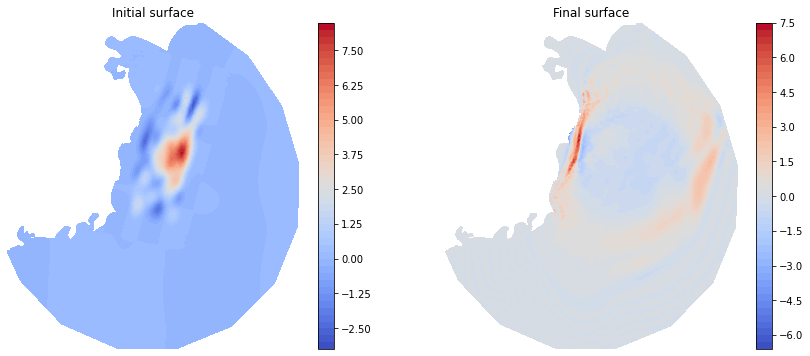

In [18]:
initial_surface.dat.name = 'Initial surface'
axes = plot_fields(initial_surface, eta, height=6)

Form the reduced functional, passing in some callbacks to print progress of the optimisation routine

In [19]:
opt_kwargs = {
    'ftol': 1.0e-03,
}

def derivative_cb_post(j, dj, ctrl):
    print("functional value {:.8e}  derivatives {:.8e}  values {:.8e}".format(j, norm(dj), norm(ctrl)))

Jhat = ReducedFunctional(J, Control(initial_surface), derivative_cb_post=derivative_cb_post)

# TODO: Use an initial scaling (`scale` kwarg to `ReducedFunctional`)

Run the minimisation routine. We just use the dolfin-adjoint default, L-BFGS.

In [20]:
ic_opt = minimize(Jhat, options=opt_kwargs)

functional value 7.36032767e+11  derivatives 3.28619377e+14  values 7.87737457e+05
functional value 7.07079840e+11  derivatives 3.13954060e+14  values 7.87564496e+05
functional value 6.11318901e+11  derivatives 2.43713814e+14  values 7.88412981e+05
functional value 6.22631362e+11  derivatives 4.18611122e+14  values 8.26258102e+05
functional value 5.11872376e+11  derivatives 2.66096807e+14  values 8.00147231e+05
functional value 4.43695337e+11  derivatives 2.31013562e+14  values 8.08386009e+05
functional value 4.13092402e+11  derivatives 1.88653656e+14  values 8.18570733e+05
functional value 3.75977844e+11  derivatives 1.58826372e+14  values 8.17129494e+05
functional value 3.71355594e+11  derivatives 2.10757897e+14  values 8.27974482e+05
functional value 3.40761677e+11  derivatives 1.08052437e+14  values 8.36433596e+05
functional value 3.30078010e+11  derivatives 1.02870163e+14  values 8.47883747e+05
functional value 3.20269993e+11  derivatives 9.68940196e+13  values 8.61405232e+05
func

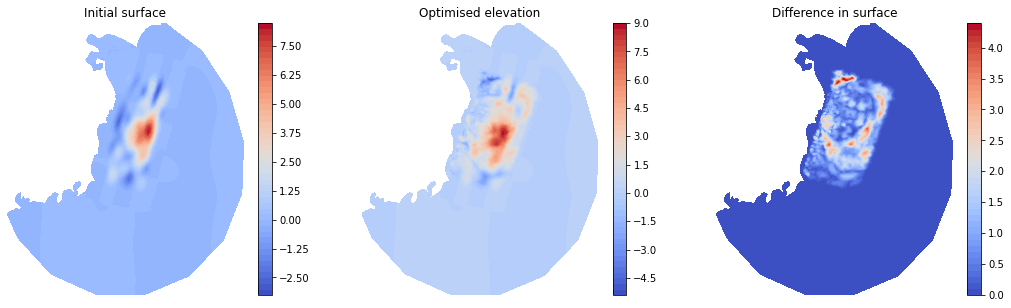

In [21]:
ic_opt.dat.name = "Optimised elevation"

surface_diff = Function(P1, name="Difference in surface")
surface_diff.interpolate(abs(initial_surface - ic_opt))

plot_fields(initial_surface, ic_opt, surface_diff);

Now that we've computed the optimised basis function, run the forward model again to see whether the timeseries match the data better.

In [22]:
with stop_annotating():
    u_.assign(0.0)
    eta_.assign(ic_opt)
    t = 0.0
    i = 0
    J_opt = 0
    i_obs = 0
    for gauge in gauges:
        op.gauges[gauge]['diff_opt'] = []
        op.gauges[gauge]['timeseries_opt'] = []
        op.gauges[gauge]['diff_smooth_opt'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx)
    while t < op.end_time:
        solver.solve()

        # Time integrate QoI
        #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
        if np.allclose(t, times[i_obs]):
            print("observation {:2d} (t = {:.2f})".format(i_obs, t))
            weight = 1.0
            if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt:
                weight = 0.5
            u, eta = q.split()
            for gauge in op.gauges:
                eta_discrete = eta.at(op.gauges[gauge]["coords"])
                if op.gauges[gauge]['init'] is None:
                    op.gauges[gauge]['init'] = eta_discrete
                eta_discrete -= op.gauges[gauge]['init']
                op.gauges[gauge]['timeseries_opt'].append(eta_discrete)
                eta_obs = op.gauges[gauge]['data'][i_obs]
                if not np.isnan(eta_obs):

                    # Discrete form
                    diff = abs(eta_discrete - eta_obs)
                    op.gauges[gauge]['diff_opt'].append(diff)

                    # Continuous form
                    diff = op.gauges[gauge]['indicator']*abs(eta - eta_obs)
                    J_inc = assemble(weight*t_obs*diff*dx)
                    J_opt += J_inc
                    op.gauges[gauge]['diff_smooth_opt'].append(assemble(diff*dx)/op.gauges[gauge]['area'])
                else:
                    op.gauges[gauge]['diff_opt'].append(np.nan)
                    op.gauges[gauge]['diff_smooth_opt'].append(np.nan)
            i_obs += 1


        q_.assign(q)
        t += op.dt
        i += 1
        if i_obs == len(times):
            break
    print("Quantity of interest = {:.4e}".format(J_opt))

observation  0 (t = 30.00)
observation  1 (t = 90.00)
observation  2 (t = 150.00)
observation  3 (t = 210.00)
observation  4 (t = 270.00)
observation  5 (t = 330.00)
observation  6 (t = 390.00)
observation  7 (t = 450.00)
observation  8 (t = 510.00)
observation  9 (t = 570.00)
observation 10 (t = 630.00)
observation 11 (t = 690.00)
observation 12 (t = 750.00)
observation 13 (t = 810.00)
observation 14 (t = 870.00)
observation 15 (t = 930.00)
observation 16 (t = 990.00)
observation 17 (t = 1050.00)
observation 18 (t = 1110.00)
observation 19 (t = 1170.00)
observation 20 (t = 1230.00)
observation 21 (t = 1290.00)
observation 22 (t = 1350.00)
observation 23 (t = 1410.00)
Quantity of interest = 2.5452e+11


In [23]:
print("Reduction in QoI value by {:.1f}%".format(100*(1-J_opt/J)))

Reduction in QoI value by 65.4%


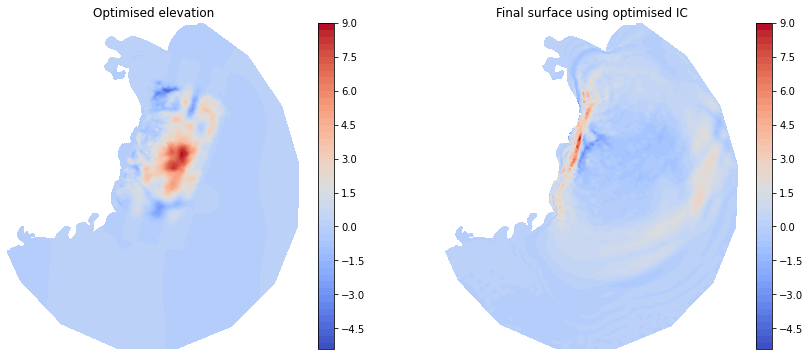

In [24]:
eta.dat.name = "Final surface using optimised IC"
plot_fields(ic_opt, eta, height=6);

Let's see how well the timeseries approximate the data at each gauge. Note that since the QoI is formed of a summation, we shouldn't expect the accuracy of every timeseries to improve and indeed some will likely be worsened.

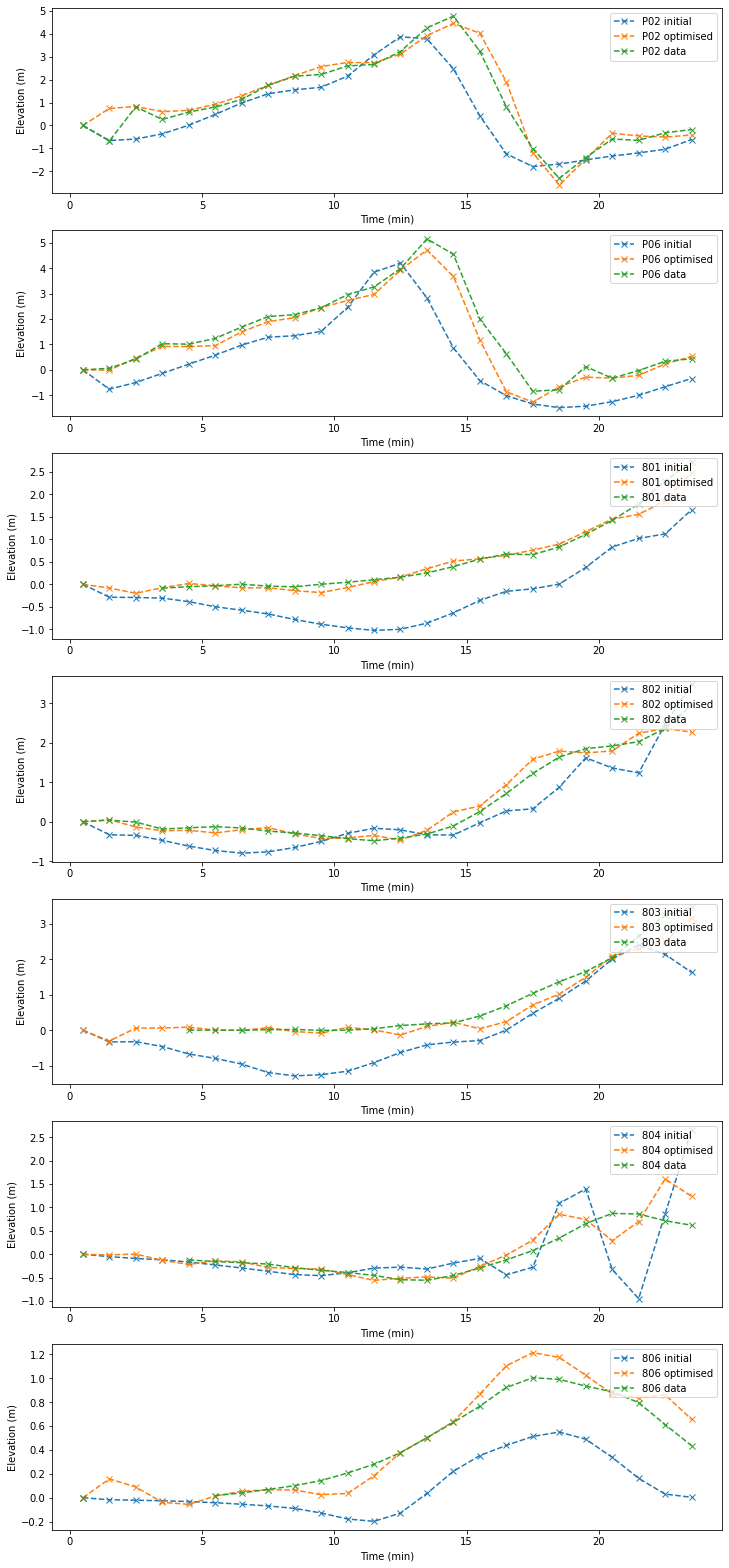

In [25]:
gauges = list(op.gauges.keys())
n = len(gauges)
fig, axes = plt.subplots(nrows=n, figsize=(12, 4*n))
for i, gauge in enumerate(gauges):
    N = len(op.gauges[gauge]['timeseries'])
    axes[i].plot(times[:N]/60, op.gauges[gauge]['timeseries'], '--x', label=gauge + ' initial')
    axes[i].plot(times[:N]/60, op.gauges[gauge]['timeseries_opt'], '--x', label=gauge + ' optimised')
    axes[i].plot(times[:N]/60, op.gauges[gauge]['data'][:N], '--x', label=gauge + ' data')
    axes[i].legend(loc='upper right')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel('Elevation (m)')

In [26]:
msg = "total variation for gauge {:s}: before {:.4e}  after {:.4e} reduction  {:.1f}%"

print("Continuous")
for gauge in gauges:
    tv = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_opt = total_variation(op.gauges[gauge]['diff_smooth_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))
    
print("\nDiscrete")
for gauge in gauges:
    tv = total_variation(op.gauges[gauge]['diff'])
    tv_opt = total_variation(op.gauges[gauge]['diff_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))

Continuous
total variation for gauge P02: before 1.0844e+01  after 5.1997e+00 reduction  52.1%
total variation for gauge P06: before 9.0269e+00  after 3.8625e+00 reduction  57.2%
total variation for gauge 801: before 1.3029e+00  after 7.6803e-01 reduction  41.1%
total variation for gauge 802: before 1.6962e+00  after 1.4396e+00 reduction  15.1%
total variation for gauge 803: before 2.0050e+00  after 7.6765e-01 reduction  61.7%
total variation for gauge 804: before 1.3331e+00  after 8.4279e-01 reduction  36.8%
total variation for gauge 806: before 7.9931e-01  after 3.8844e-01 reduction  51.4%

Discrete
total variation for gauge P02: before 9.9785e+00  after 6.8502e+00 reduction  31.4%
total variation for gauge P06: before 1.1435e+01  after 5.1278e+00 reduction  55.2%
total variation for gauge 801: before 2.3252e+00  after 1.5983e+00 reduction  31.3%
total variation for gauge 802: before 5.0142e+00  after 2.8367e+00 reduction  43.4%
total variation for gauge 803: before 4.0216e+00  after

In [27]:
tape = get_working_tape()
blocks = tape.get_blocks()
solve_blocks = [block for block in blocks if isinstance(block, SolveVarFormBlock)]
N = len(solve_blocks)
for i, block in enumerate(solve_blocks):
    if block.adj_sol is not None:
        print("{:d}/{:d}".format(i+1, N))

1/1
